**Weekly Model**
**Training Phase**

22:37:03 - cmdstanpy - INFO - Chain [1] start processing
22:37:03 - cmdstanpy - INFO - Chain [1] done processing
22:37:04 - cmdstanpy - INFO - Chain [1] start processing
22:37:04 - cmdstanpy - INFO - Chain [1] done processing


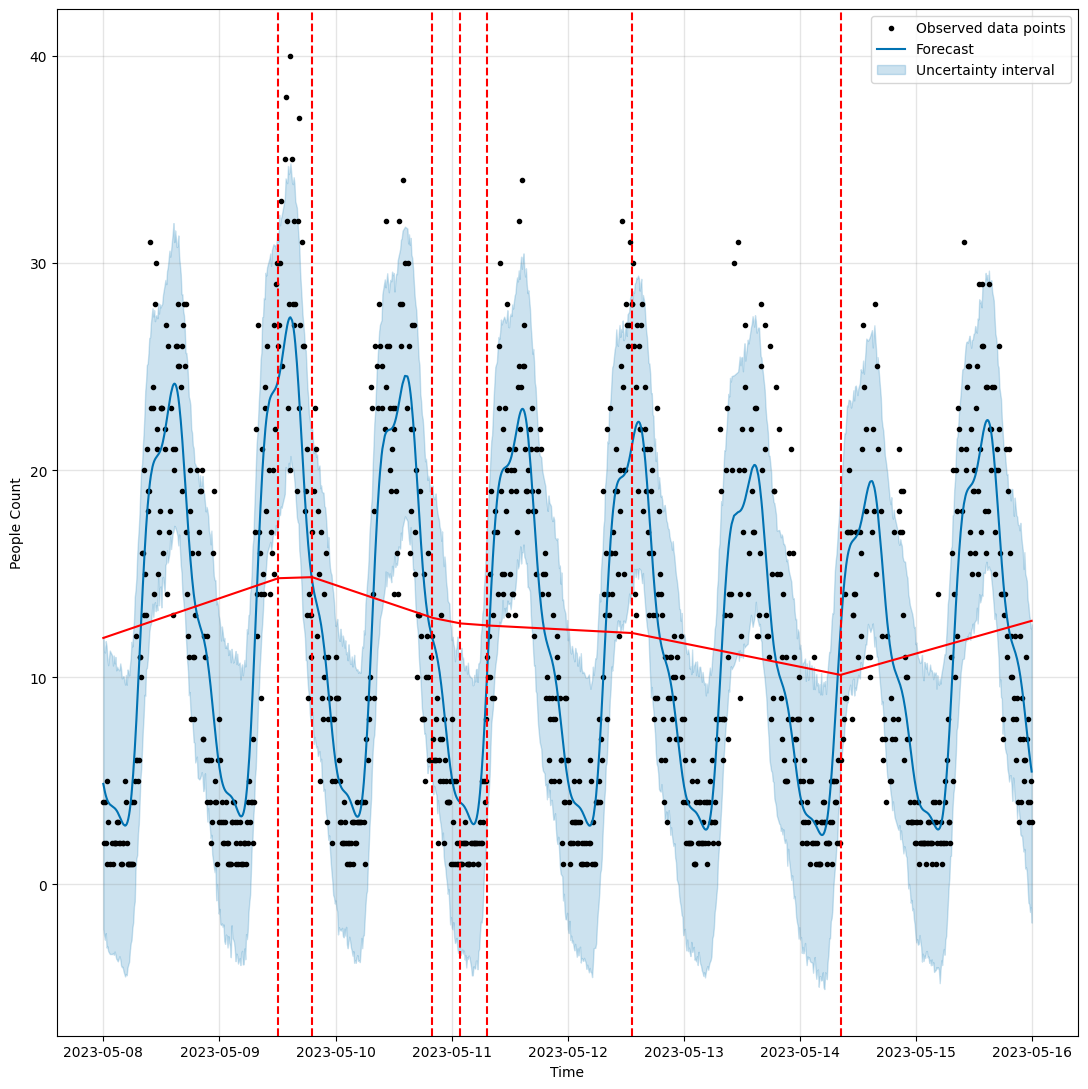

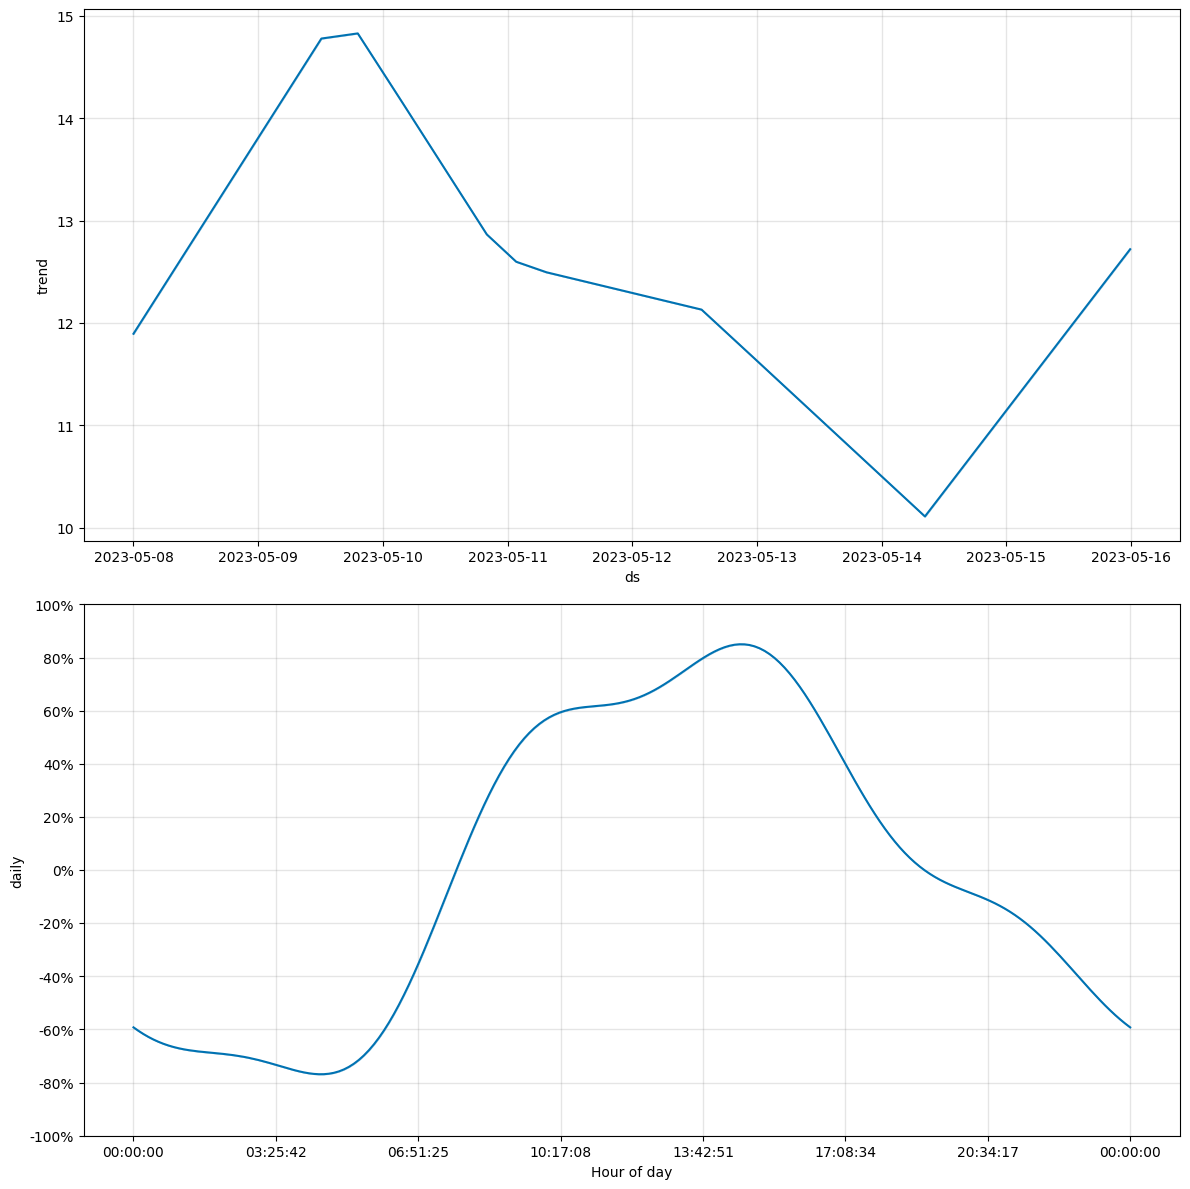

In [1]:
import pandas as pd
import pytz
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from scipy import stats

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

df = pd.read_csv('May.csv', parse_dates=['time'])

# Convert to CET and remove timezone information
cet_timezone = pytz.timezone('CET')
df['time'] = df['time'].dt.tz_localize('UTC').dt.tz_convert(cet_timezone).dt.tz_localize(None)

# Choose the start date and end date for the one-week subset
start_date = '2023-05-08 00:00:00'
end_date = '2023-05-15 23:59:59'

# Filter the DataFrame to include only the data for the selected week
selected_week_data = df[(df['time'] >= start_date) & (df['time'] <= end_date)]

# # Display the selected week data
# print(selected_week_data)

# Create the training set
training_set = pd.DataFrame({'ds': selected_week_data['time'], 'y': selected_week_data['people_count']})


# Initialize and fit the Prophet model for 1 week

dummy_weekly_training_model = Prophet(seasonality_mode='multiplicative',daily_seasonality=4,seasonality_prior_scale=0.05,interval_width=0.90)

dummy_weekly_training_model.fit(training_set)

# Make predictions
dummy_weekly_forecast = dummy_weekly_training_model.predict()

#Filter the outliers
filtered_training_set = training_set[(training_set['y'] > dummy_weekly_forecast['yhat_lower'].values) & (training_set['y'] < dummy_weekly_forecast['yhat_upper'].values)]
#ignore the values which are above and below 90% UI

weekly_training_model = Prophet(seasonality_mode='multiplicative',daily_seasonality=4,seasonality_prior_scale=0.05,changepoint_prior_scale=0.09,interval_width=0.90)

weekly_training_model.fit(filtered_training_set)

# Create a future DataFrame for predictions
future = weekly_training_model.make_future_dataframe(periods=6*24, freq='10min')


# Make predictions
weekly_forecast = weekly_training_model.predict()

fig = weekly_training_model.plot(weekly_forecast,figsize=(11,11),include_legend=True,xlabel="Time",ylabel="People Count")

# Plot the forecast
# fig_1 = weekly_training_model.plot(weekly_forecast,figsize=(15,15))
fig_2 = weekly_training_model.plot_components(weekly_forecast,figsize=(12,12))

#Identifying the trend
add_changepoints_to_plot(fig.gca(), weekly_training_model, weekly_forecast)
plt.show()


**Weekly model Testing Phase**

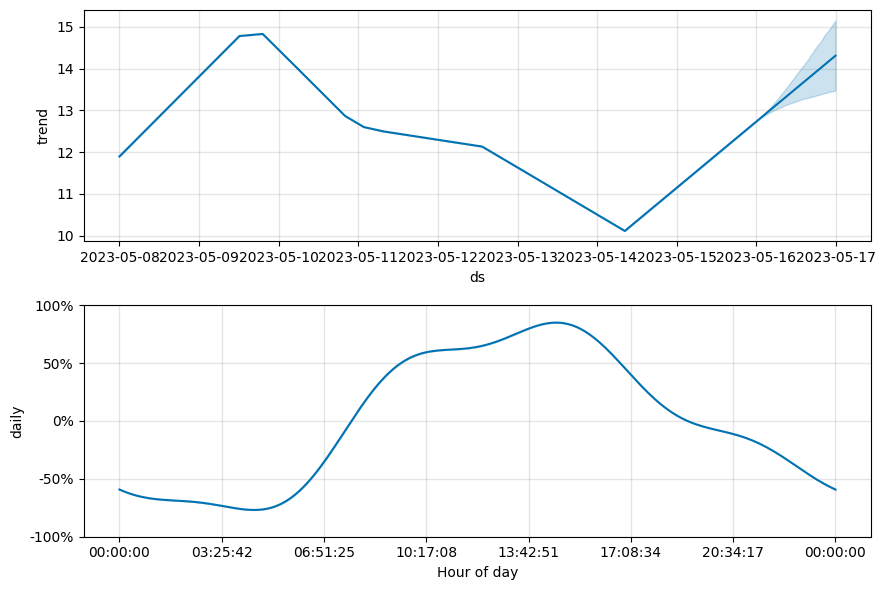

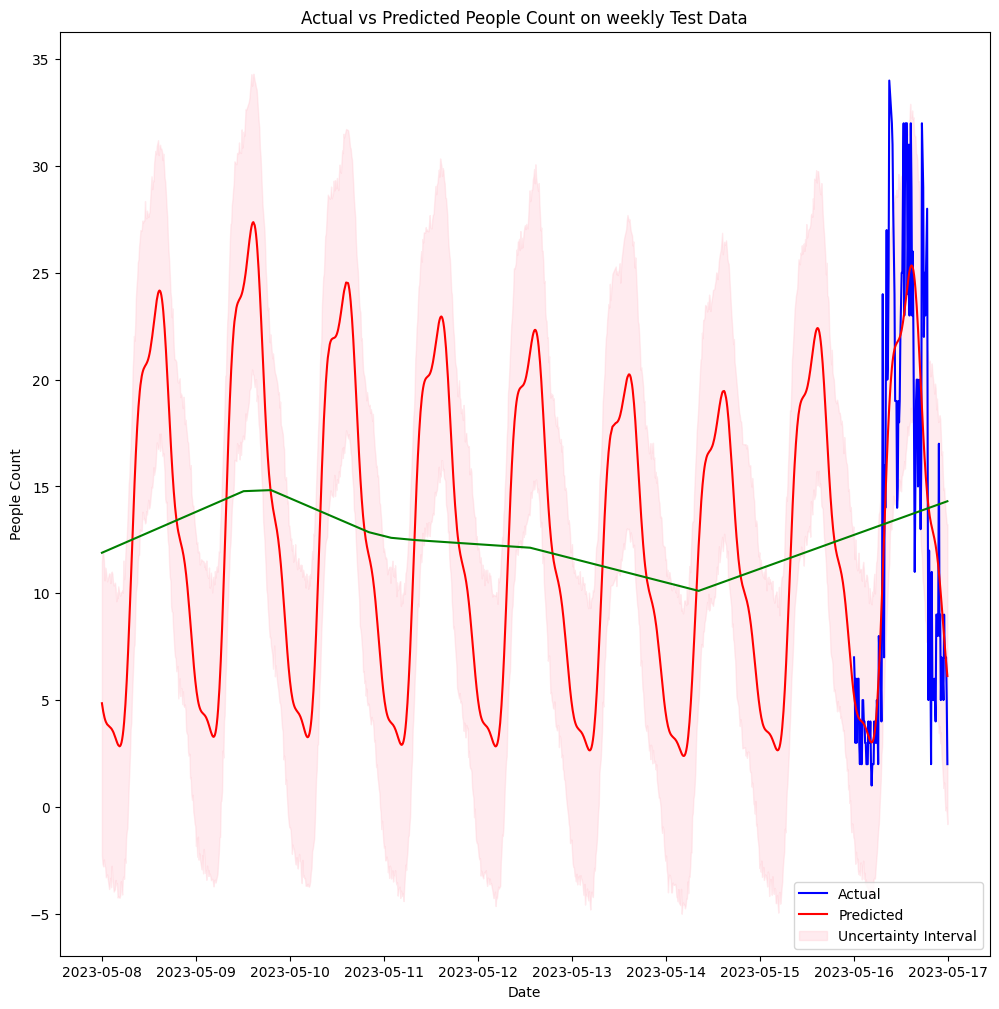

In [2]:
from prophet.plot import plot_components


# containing datetime values for the test period
df_test = pd.read_csv('May.csv', parse_dates=['time'])

# Convert to CET and remove timezone information
cet_timezone = pytz.timezone('CET')
df_test['time'] = df_test['time'].dt.tz_localize('UTC').dt.tz_convert(cet_timezone).dt.tz_localize(None)


# Choose the start date and end date for the one-week subset
test_start_date = '2023-05-16 00:00:00'
test_end_date = '2023-05-16 23:59:59'

# Filter the DataFrame to include only the data for the selected week
selected_week_data = df_test[(df_test['time'] >= test_start_date) & (df_test['time'] <= test_end_date)]

# print(selected_week_data)
# Create the testing set

weekly_testing_set = pd.DataFrame({'ds': selected_week_data['time'], 'y': selected_week_data['people_count']})

#Working on dealing with outliers

outliers_df = weekly_testing_set[(stats.zscore(weekly_testing_set['y'])<1.65)]


testing_set = outliers_df

# Create a future DataFrame for the test data
weekly_future_test = weekly_training_model.make_future_dataframe(periods=6*24, freq='10min')

# Make predictions on the test data
weekly_forecast_test = weekly_training_model.predict(weekly_future_test)

fig3 = plot_components(weekly_training_model,weekly_forecast_test)




# Plot the actual vs predicted values for the test period
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(testing_set['ds'], testing_set['y'], label='Actual', color='blue')
ax.plot(weekly_forecast_test['ds'], weekly_forecast_test['yhat'], label='Predicted', color='red')
ax.fill_between(weekly_forecast_test['ds'], weekly_forecast_test['yhat_lower'], weekly_forecast_test['yhat_upper'], color='pink', alpha=0.3, label='Uncertainty Interval')
ax.legend()
plt.xlabel('Date')
plt.ylabel('People Count')
plt.title('Actual vs Predicted People Count on weekly Test Data')
add_changepoints_to_plot(fig.gca(), weekly_training_model, weekly_forecast_test,cp_linestyle='',cp_color='green')
plt.show()